In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import os
import requests
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from wordcloud import WordCloud
from PIL import Image
import tweepy
import json

## Gathering data

### 1. Get twitter archive

In [2]:
df_enhanced = pd.read_csv("twitter-archive-enhanced.csv")
df_enhanced.shape

(2356, 17)

In [3]:
df_enhanced.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


In [4]:
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [5]:
# no duplicates in tweet id
df_enhanced.tweet_id.drop_duplicates().shape

(2356,)

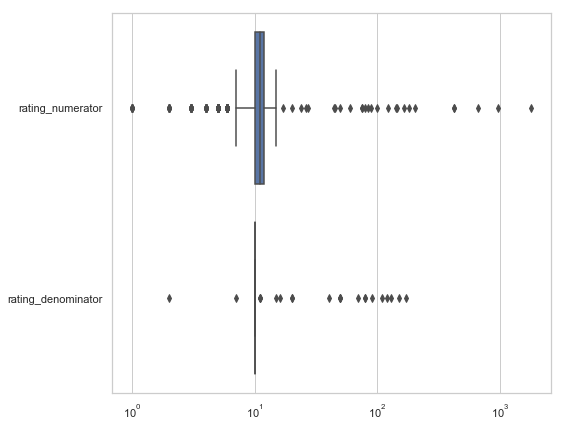

In [69]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sns.boxplot(data=df_enhanced[['rating_numerator', 'rating_denominator']], orient='h', ax=ax)

In [70]:
df_enhanced.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [8]:
# number of retweeted tweets
df_enhanced[df_enhanced.retweeted_status_id.notna()].shape

(181, 17)

In [9]:
df_enhanced.name.value_counts()

None        745
a           55 
Charlie     12 
Lucy        11 
Cooper      11 
Oliver      11 
Tucker      10 
Lola        10 
Penny       10 
Winston     9  
Bo          9  
Sadie       8  
the         8  
an          7  
Toby        7  
Buddy       7  
Bailey      7  
Daisy       7  
Rusty       6  
Milo        6  
Dave        6  
Leo         6  
Koda        6  
Stanley     6  
Jax         6  
Oscar       6  
Bella       6  
Scout       6  
Jack        6  
Louis       5  
           ..  
Pancake     1  
Rilo        1  
Freddery    1  
Cal         1  
Nugget      1  
Moofasa     1  
Mollie      1  
Barry       1  
Mimosa      1  
Dido        1  
Filup       1  
Monster     1  
Alfy        1  
Arlen       1  
Joey        1  
Ambrose     1  
Godi        1  
Scott       1  
Dewey       1  
Bruiser     1  
Augie       1  
Chaz        1  
Ziva        1  
Carll       1  
Tino        1  
Jessifer    1  
Smiley      1  
Blakely     1  
Monkey      1  
JD          1  
Name: name, Length: 957,

### 2. Get image predictions from udacity

In [10]:
# get tweet data from udacity using requests library
def get_image_predictions(fname):
    if not os.path.exists(fname):
        pred_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/{}".format(fname)
        resp = requests.get(pred_url)
        if resp.ok:
            print("got file remotely... ok")
            with open(fname, "w") as f:
                f.write(resp.text)
    df = pd.read_csv(fname, sep="\t")
    assert len(df) > 0, "can't get image predictions"
    return df

In [11]:
df_im_pred = get_image_predictions("image-predictions.tsv")
df_im_pred.shape

(2075, 12)

In [12]:
df_im_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
df_im_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [71]:
df_im_pred[df_im_pred.p1_dog].shape

(1532, 12)

In [14]:
df_im_pred[df_im_pred.p1_dog | df_im_pred.p2_dog | df_im_pred.p3_dog].shape

(1751, 12)

### 3. Get tweets from twitter by tweet ids

In [ ]:
tweeter_creds = json.load(open(os.path.expanduser("~/.twitter_secrets")))
consumer_key = tweeter_creds['tweeter_consumer_key']
consumer_secret = tweeter_creds['tweeter_consumer_secret']
access_token = tweeter_creds['tweeter_access_token']
access_token_secret = tweeter_creds['tweeter_access_token_secret']

In [67]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

def test_tweeter_api():
    public_tweets = api.home_timeline()
    for tweet in public_tweets:
        print(tweet.text)
test_tweeter_api()

Hello tweet!


In [16]:
def get_all_tweets(tweet_ids, fname):
    if not os.path.exists(fname):
        fail_dict = dict()
        with open(fname, 'w') as f:
            for tweet_id in tweet_ids:
                try:
                    tweet = api.get_status(tweet_id, tweet_mode='extended')
                    json.dump(tweet._json, f)
                    f.write('\n')
                except tweepy.TweepError as e:
                    print("fail")
                    fail_dict[tweet_id] = e
        print(fail_dict)
        with open("fail_dict.txt", "w") as ff:
            ff.write(fail_dict)
    data = []
    line = True
    with open(fname, 'r') as f:
        while line:
            line = f.readline()
            line = line.strip()
            if line:
                js = json.loads(line)
                data.append(js)
    return data

In [17]:
tweet_ids = df_enhanced.tweet_id
data = get_all_tweets(tweet_ids, 'tweet_json.txt')

In [18]:
# we had 9 failures, original number of tweet ids was 2075, minus 9 equals to 2066
len(data)

2066

In [19]:
from tweepy import TweepError
lines = open("fail_dict.txt").readlines()
line = lines[0].strip()
errors = eval(line)
print("Invalid tweet_ids: {}".format(errors.keys()))

Invalid tweet_ids: dict_keys([680055455951884288, 754011816964026368, 802247111496568832, 837012587749474308, 842892208864923648, 861769973181624320, 872261713294495745, 873697596434513921, 888202515573088257])


### 4. Reading downloaded tweets into dataframe

In [20]:
df_data = pd.DataFrame(data)
df_data.shape

(2066, 28)

In [21]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 28 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2066 non-null object
display_text_range               2066 non-null object
entities                         2066 non-null object
extended_entities                2065 non-null object
favorite_count                   2066 non-null int64
favorited                        2066 non-null bool
full_text                        2066 non-null object
geo                              0 non-null object
id                               2066 non-null int64
id_str                           2066 non-null object
in_reply_to_screen_name          23 non-null object
in_reply_to_status_id            23 non-null float64
in_reply_to_status_id_str        23 non-null object
in_reply_to_user_id              23 non-null float64
in_reply_to_user_id_str          23 non-null obj

## Cleaning data

#### df_enhanced table

In [22]:
# remove retweets
df1 = df_enhanced[df_enhanced.retweeted_status_id.isnull()]
df1.shape

(2175, 17)

In [23]:
# remove all columns related to retweet
df1_cols = [c for c in df1.columns if not c.startswith("retweet") and not c.startswith("in_reply")]
df1_cols

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [24]:
df1 = df1[df1_cols]

In [25]:
# set timestamp to datetime data type
df1.timestamp = pd.to_datetime(df1.timestamp)

In [26]:
# fix zero rating denominator
# we can see from the text that the rating should be 13/10
df0 = df1[df1.rating_denominator <= 0]
df0

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,960,0,None,None,None,None,None


In [27]:
df1.loc[df0.index, "rating_denominator"] = 10
df1.loc[df0.index, "rating_numerator"] = 13 

In [28]:
# replace None with empty string
df1 = df1.replace('None', '')

In [29]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 300.9+ KB


In [30]:
df1.doggo = df1.doggo.astype(bool)
df1.floofer = df1.floofer.astype(bool)
df1.pupper = df1.pupper.astype(bool)
df1.puppo = df1.puppo.astype(bool)

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null bool
floofer               2175 non-null bool
pupper                2175 non-null bool
puppo                 2175 non-null bool
dtypes: bool(4), datetime64[ns](1), int64(3), object(4)
memory usage: 241.4+ KB


### df_im_pred table

In [32]:
df_im_pred.shape

(2075, 12)

In [33]:
df2 = df_im_pred[df_im_pred.p1_dog | df_im_pred.p2_dog | df_im_pred.p3_dog]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1751 non-null int64
jpg_url     1751 non-null object
img_num     1751 non-null int64
p1          1751 non-null object
p1_conf     1751 non-null float64
p1_dog      1751 non-null bool
p2          1751 non-null object
p2_conf     1751 non-null float64
p2_dog      1751 non-null bool
p3          1751 non-null object
p3_conf     1751 non-null float64
p3_dog      1751 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 141.9+ KB


### df_data table

In [34]:
df_data.shape

(2066, 28)

In [35]:
df3_cols = ['id', 'favorite_count', 'lang', 'retweet_count']
df3 = df_data[df3_cols]
df3.columns = ['tweet_id'] + df3_cols[1:]

In [36]:
df3.head()

,tweet_id,favorite_count,lang,retweet_count
0,666020888022790149,2526,en,498
1,666029285002620928,125,en,46
2,666033412701032449,122,en,43
3,666044226329800704,290,en,136
4,666049248165822465,105,en,42


In [37]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 4 columns):
tweet_id          2066 non-null int64
favorite_count    2066 non-null int64
lang              2066 non-null object
retweet_count     2066 non-null int64
dtypes: int64(3), object(1)
memory usage: 64.6+ KB


In [38]:
df = pd.merge(df1, df2, how='inner', on='tweet_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 0 to 1685
Data columns (total 23 columns):
tweet_id              1686 non-null int64
timestamp             1686 non-null datetime64[ns]
source                1686 non-null object
text                  1686 non-null object
expanded_urls         1686 non-null object
rating_numerator      1686 non-null int64
rating_denominator    1686 non-null int64
name                  1686 non-null object
doggo                 1686 non-null bool
floofer               1686 non-null bool
pupper                1686 non-null bool
puppo                 1686 non-null bool
jpg_url               1686 non-null object
img_num               1686 non-null int64
p1                    1686 non-null object
p1_conf               1686 non-null float64
p1_dog                1686 non-null bool
p2                    1686 non-null object
p2_conf               1686 non-null float64
p2_dog                1686 non-null bool
p3                    1686 non-null obj

In [39]:
df = pd.merge(df, df3, how='inner', on='tweet_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 0 to 1682
Data columns (total 26 columns):
tweet_id              1683 non-null int64
timestamp             1683 non-null datetime64[ns]
source                1683 non-null object
text                  1683 non-null object
expanded_urls         1683 non-null object
rating_numerator      1683 non-null int64
rating_denominator    1683 non-null int64
name                  1683 non-null object
doggo                 1683 non-null bool
floofer               1683 non-null bool
pupper                1683 non-null bool
puppo                 1683 non-null bool
jpg_url               1683 non-null object
img_num               1683 non-null int64
p1                    1683 non-null object
p1_conf               1683 non-null float64
p1_dog                1683 non-null bool
p2                    1683 non-null object
p2_conf               1683 non-null float64
p2_dog                1683 non-null bool
p3                    1683 non-null obj

In [40]:
df.to_csv("master-dataset.csv")

##  Data analysis

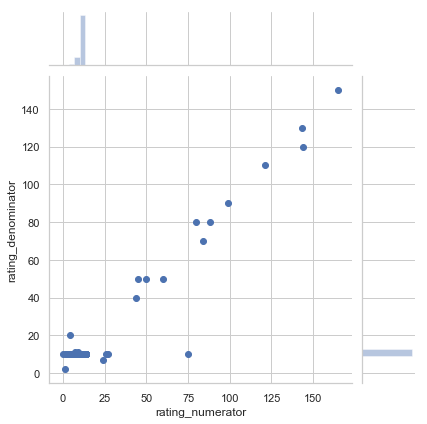

In [73]:
import warnings
warnings.filterwarnings("ignore")
sns.jointplot(x="rating_numerator", y="rating_denominator", data=df)

* most of the ratings more thant 10 and are 10-based
* those that go to large number can be easily scaled back to 10-base rating since numerator/denominator are linear correlated

Text(0.5, 1.0, 'Favorite vs retweets')

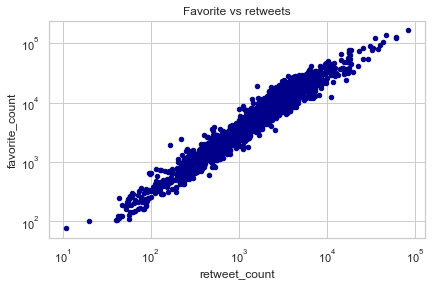

In [42]:
df.plot.scatter(x='retweet_count', y='favorite_count', c="DarkBlue")
plt.yscale('log')
plt.xscale('log')
plt.title("Favorite vs retweets")

* we can see perfect linear relation between retweet count and favorite count

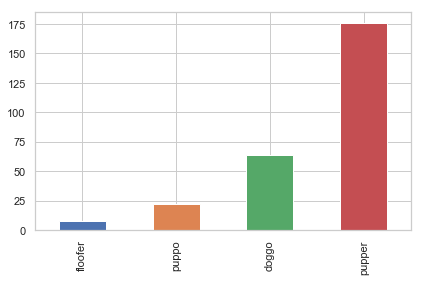

In [43]:
# note that the majority of pictures are actually unknown
df_stage = df[['floofer', 'puppo', 'doggo', 'pupper']]
df_stage.sum().plot.bar()

* most popular dog "stage" (or most recognized by image detection) is pupper

In [44]:
# let's see top 20 breeds
top20 = df.p1.value_counts()[:20]
y, x = top20.index, top20.values

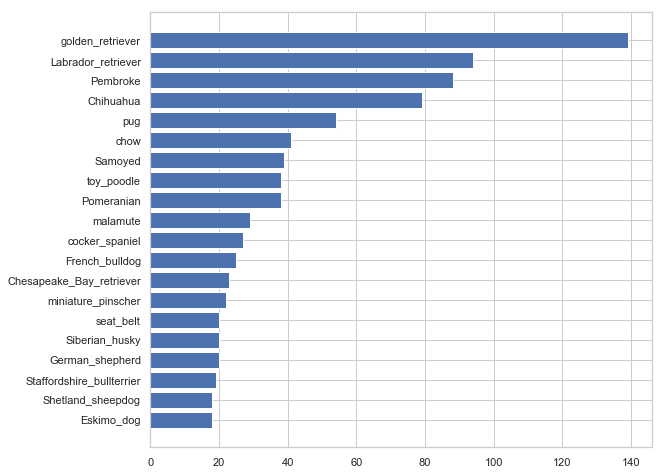

In [45]:
fig, ax = plt.subplots(figsize=[8, 8])
yticks = np.arange(len(y))
ax.barh(yticks, x)
ax.set_yticks(yticks)
ax.set_yticklabels(y)
ax.invert_yaxis()
plt.show()

* top breeds are retrievers, pembroke and chihuahua

In [46]:
# let's make breed tag plot
text = " ".join(list(df['p1'].values))

In [47]:
# image source: https://media.pixcove.com/A/8/5/Dog-Canine-Friend-Pet-Free-Illustrations-Free-Imag-3975.jpg
dog_mask = np.array(Image.open("dog-image.jpg"))

In [48]:
def transform_format(val):
    val = val[-1]
    if val == 0:
        return 255
    else:
        return val
    
transformed_mask = np.ndarray((dog_mask.shape[0], dog_mask.shape[1]), np.int32)

for i in range(len(dog_mask)):
    transformed_mask[i] = list(map(transform_format, dog_mask[i]))

In [49]:
wordcloud = WordCloud(max_font_size=70, max_words=100, background_color="white", mask=transformed_mask, contour_width=1, contour_color='darkblue')
wc = wordcloud.generate(text)

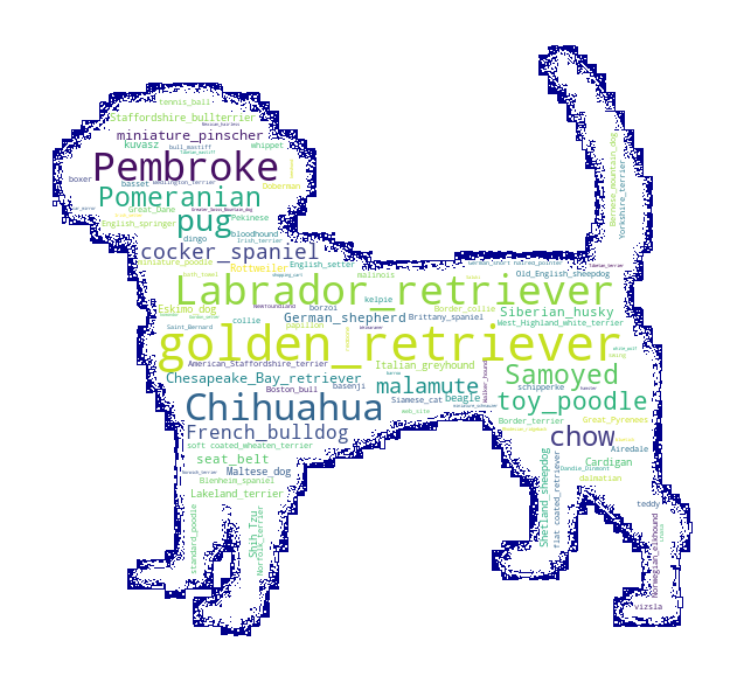

In [50]:
plt.figure(figsize=[15, 12])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()